In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython){
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import glob
import itertools
from openpyxl import load_workbook
from tqdm.auto import tqdm
import models as md
import log_results as lr
import matplotlib.pyplot as plt
%matplotlib inline

### Exploration

In [3]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
# data exploration - looking for empty values
data.count().unique()

array([299])

### Simple model example

In [5]:
TT = md.TreeTester(data=data,target='DEATH_EVENT')
TT.evaluate()

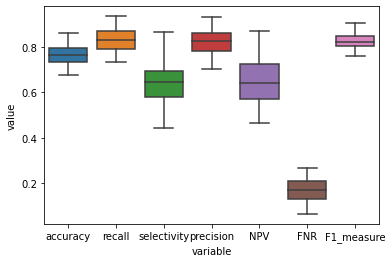

In [6]:
TT.plot_results()

### Running and saving

In [12]:
# Look for already existing results dataframes, define "this test number" as "last test number + 1"
test_df_list = glob.glob("results/df/*.pkl")
try:
    test_no = max([int(elem.replace("results/df/","").replace(".pkl","").replace("df","")) for elem in test_df_list])+1
except:
    test_no = 0
    
# Test details
features = list(data.drop(['time','DEATH_EVENT'],axis=1).columns)
auto_train = True
added_features = 1
oversample = True
df_name = f'df{test_no}'

# Running model and saving results
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT',oversample=oversample,
                   auto_train=auto_train,added_features=added_features)
TT.evaluate()
TT.evaluators.to_pickle(f'results/df/{df_name}.pkl')

# Updating test log file
results_logger = lr.Logger(oversample=oversample,features=features,df_name=df_name,
                           auto_train=auto_train,added_features=added_features)
results_logger.update_log()

In [13]:
test_log = pd.read_excel('results/df/test_log.xlsx').drop(['Unnamed: 0'],axis=1)
test_log

,auto_train,added_features,oversample,features,train_size,robustness_iterations,results_df
0,False,0,False,"['age', 'anaemia', 'creatinine_phosphokinase',...",0.66,100,df0
1,False,0,True,"['age', 'anaemia', 'creatinine_phosphokinase',...",0.66,100,df1
2,True,1,False,"['age', 'anaemia', 'creatinine_phosphokinase',...",0.66,100,df2
3,True,1,True,"['age', 'anaemia', 'creatinine_phosphokinase',...",0.66,100,df3


In [ ]:
# feature selection

results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for column in tqdm(data.drop(['DEATH_EVENT','time'],axis=1).columns):
    TT = md.TreeTester(data=data.drop([column],axis=1),target='DEATH_EVENT')
    TT.evaluate()
    results[column] = TT.evaluators.mean()

In [ ]:
# feature selection

auto_train = False
added_features = 0
oversample = False
forced_features = None

line_info = {
    'auto_train': auto_train,
    'n_features': added_features,
    'oversample': oversample,
    'forced_features': forced_features
}

results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','DEATH_EVENT'],axis=1).columns, 2))):
    TT = md.TreeTester(data=data,features=list(item),target='DEATH_EVENT')
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:

auto_train = False
added_features = 121
oversample = False
forced_features = ['age','sex']

line_info = {
    'auto_train': auto_train,
    'n_features': added_features,
    'oversample': oversample,
    'forced_features': forced_features
}

try:
    book = load_workbook('results/df/test_log.xlsx')
    book = load_workbook('results/df/test_log.xlsx')
    writer = pd.ExcelWriter('results/df/test_log.xlsx', engine='openpyxl') 
    writer.book = book
    writer.book = book
    writer.sheets = {ws.title: ws for ws in book.worksheets}
    for sheetname in writer.sheets:
        pd.DataFrame([line_info]).to_excel(writer,sheet_name=sheetname, startrow=writer.sheets[sheetname].max_row,
                                           index = True,header= False)

    writer.save()
except: 
    print('No test log file - creating one')
    pd.DataFrame([line_info]).to_excel('results/df/test_log.xlsx')

In [ ]:
# feature selection
import itertools

results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','DEATH_EVENT'],axis=1).columns, 2))):
    TT = md.TreeTester(data=data,features=list(item),target='DEATH_EVENT')
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','DEATH_EVENT'],axis=1).columns, 3))):
    TT = md.TreeTester(data=data,features=list(item),target='DEATH_EVENT')
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','sex','age','smoking','DEATH_EVENT'],axis=1).columns, 2))):
    TT = md.TreeTester(data=data,features=['sex','age','smoking']+list(item),target='DEATH_EVENT')
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','sex','age','smoking','DEATH_EVENT'],axis=1).columns, 3))):
    TT = md.TreeTester(data=data,features=['sex','age','smoking']+list(item),target='DEATH_EVENT')
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
# oversampling

results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','DEATH_EVENT'],axis=1).columns, 2))):
    TT = md.TreeTester(data=data,features=list(item),target='DEATH_EVENT',oversample=True)
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
# oversampling

results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','sex','age','smoking','DEATH_EVENT'],axis=1).columns, 2))):
    TT = md.TreeTester(data=data,features=['sex','age','smoking']+list(item),target='DEATH_EVENT',oversample=True)
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
# oversampling

results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','sex','age','smoking','DEATH_EVENT'],axis=1).columns, 2))):
    TT = md.TreeTester(data=data,features=['sex','age','smoking']+list(item),target='DEATH_EVENT',oversample=True,
                       auto_train=True,added_features=1)
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
# feature selection
results = {}
TT = md.TreeTester(data=data.drop(['time'],axis=1),target='DEATH_EVENT')
TT.evaluate()
results['all_set'] = TT.evaluators.mean()

for item in tqdm(list(itertools.combinations(data.drop(['time','DEATH_EVENT'],axis=1).columns, 2))):
    TT = md.TreeTester(data=data,features=list(item),target='DEATH_EVENT',oversample=True,
                       auto_train=True,added_features=1)
    TT.evaluate()
    results[item] = TT.evaluators.mean()

In [ ]:
results_df = pd.DataFrame.from_dict(results).round(3)
results_df = results_df[results_df.iloc[2,:].sort_values().index[::-1]]
results_df

In [ ]:
results_df[list(results_df.columns)[10:40]]

In [ ]:
TT.plot_results()